In [2]:
from rdkit import Chem
import pandas as pd

In [124]:
df = pd.read_csv('compare_0206.csv')
Lowe_smiles = df['Lowe_smiles'].tolist()
GPT_smiles = df['GPT_smiles'].tolist()
titles = df['nameResolved'].tolist()
paragraphs = df['original_paragraph'].tolist()
responses = df['json_responses'].tolist()
df.head(3)

,Unnamed: 0,processed_random_samples_Index,temp_compare_Index,documentId,paragraphNum,file_path,headingText,nameResolved,template,productSmiles,original_paragraph,Lowe_smiles,GPT response,json_responses,smiles_dict,fix_rxn_smiles,GPT_smiles
0,0,25,49825,US20060252807A1,601.0,C:/2001_Sep2016_USPTOapplications_cml/applicat...,Step 1 4-(4-Ethoxycarbonyl-oxazol-2-ylethynyl)...,4-(4-Ethoxycarbonyl-oxazol-2-ylethynyl)-piperi...,[C:1]#[C:2].[X:6]-[c:3](:[a:4]):[a:5]>>[C:1]#[...,CCOC(=O)c1coc(C#CC2CCN(C(=O)OC(C)(C)C)CC2)n1,A 50 mL round bottom flask was charged with 2-...,[CH2:1]([O:3][C:4]([C:6]1[N:7]=[C:8](Cl)[O:9][...,"{\n ""Reactants, Solvents, and Catalysts"": {\n...","{'Reactants, Solvents, and Catalysts': {'A': '...","{'A': 'CCOC(=O)C1=COC(=N1)Cl', 'B': 'CC(C)(C)O...","{'Reactants, Solvents, and Catalysts': {'A': '...",C1=CC=C(C=C1)[PH+](C2=CC=CC=C2)C3=CC=CC=C3.C1=...
1,1,25,49827,US20060252807A1,626.0,C:/2001_Sep2016_USPTOapplications_cml/applicat...,4-(4-Ethoxycarbonyl-oxazol-2-ylethynyl)-piperi...,4-(4-Ethoxycarbonyl-oxazol-2-ylethynyl)-piperi...,[C:1]#[C:2].[X:6]-[c:3](:[a:4]):[a:5]>>[C:1]#[...,CCOC(=O)c1coc(C#CC2CCN(C(=O)OC(C)(C)C)CC2)n1,A 50 mL round bottom flask was charged with 2-...,[CH2:1]([O:3][C:4]([C:6]1[N:7]=[C:8](Cl)[O:9][...,"{\n ""Reactants, Solvents, and Catalysts"": {\n...","{'Reactants, Solvents, and Catalysts': {'A': '...","{'A': 'CCOC(=O)C1=COC(=N1)Cl', 'B': 'CC(C)(C)O...","{'Reactants, Solvents, and Catalysts': {'A': '...",C1=CC=C(C=C1)[PH+](C2=CC=CC=C2)C3=CC=CC=C3.C1=...
2,2,51,42330,US20040044000A1,894.0,C:/2001_Sep2016_USPTOapplications_cml/applicat...,Step (2): 2-(4-fluorobenzyl)-7-3-phenylprop-1-...,2-(4-fluorobenzyl)-7-3-phenylprop-1-ynyl-2H-is...,[C:1]#[C:2].[X:6]-[c:3](:[a:4]):[a:5]>>[C:1]#[...,O=c1c2cc(C#CCc3ccccc3)ccc2ccn1Cc1ccc(F)cc1,The coupling of 7-bromo-2-(4-fluorobenzyl)-2H-...,Br[C:2]1[CH:11]=[C:10]2[C:5]([CH:6]=[CH:7][N:8...,"**Output:**\n\n```\n{\n ""Reactants, Solvents,...","(3, 'Failed to parse JSON')",No smiles_dict(Failed to parse JSON),Failed to parse JSON,NaN


In [90]:
def demap(smiles, return_role=False):
    mol = Chem.MolFromSmiles(smiles)
    is_reactant = False
    for atom in mol.GetAtoms():
        if atom.GetAtomMapNum() != 0:
            is_reactant = True
            atom.SetAtomMapNum(0)
    if return_role:
        return Chem.MolToSmiles(mol), is_reactant
    else:
        return Chem.MolToSmiles(mol)

def split_role(rxn):
    reactants, reagents, product = rxn.split('>')
    if not reagents:
        real_reactants, real_reagents = [], []
    else:
        real_reactants, real_reagents = [], [demap(reagents)]
    for reactant in reactants.split('.'):
        smiles, is_reactant = demap(reactant, True)
        if is_reactant:
            real_reactants.append(smiles)
        else:
            real_reagents.append(smiles)
    return real_reactants, real_reagents, demap(product)

In [132]:
def compare_results(i):
    title = titles[i]
    paragraph = paragraphs[i]
    response = responses[i]
    rxn1 = Lowe_smiles[i]
    rxn2 = GPT_smiles[i]
    if str(rxn2) in ['>>', 'nan']:
        result = {
            'title': title, 
            'paragraph': paragraph, 
            'response': response,
            'Lowe_rxn': rxn1,
            'GPT_rxn': None,
            'reactant_match': False,
            'reagent_match': False, 
            'product_match': False,
            'rxn_match': False
        }
        return result
    reactants1, reagents1, products1 = split_role(rxn1)
    reactants_reagents2, products2 = [demap(smi) for smi in rxn2.split('>>')]
    reactants2, reagents2 = [], []
    for smi in reactants_reagents2.split('.'):
        if smi in reactants1:
            reactants2.append(smi)
        else:
            reagents2.append(smi)
    
    rxn1 = '.'.join(sorted(reactants1+reagents1)) + '>>' + products1
    rxn2 = '.'.join(sorted(reactants2+reagents2)) + '>>' + products2
    result = {
        'title': title, 
        'paragraph': paragraph, 
        'response': response,
        'Lowe_rxn': rxn1,
        'GPT_rxn': rxn2,
        'reactant_match': set(reactants1) == set(reactants2),
        'reagent_match': set(reagents1) == set(reagents2), 
        'product_match': products1 == products2,
        'rxn_match': rxn1 == rxn2
    }
    return result

i = 5
results = compare_results(i)
results

{'title': '4-[(3-Bromophenyl)ethynyl]-1H-pyrrole-2-carbaldehyde',
 'paragraph': 'A solution of 4-iodo-1H-pyrrole-2-carbaldehyde (0.50 g; 2.262 mmol) and bis(triphenylphosphine)palladium-(II)chloride (0.079 g; 0.113 mmol)) in DMF (15 mL; degassed with nitrogen for 30 minutes) was stirred at ambient temperature for 15 minutes. Then the following were added: 1-bromo-3-ethynylbenzene (0.61 g; 3.394 mmol), copper iodide (43 mg; 0.226), and triethylamine (1.58 mL, 11.3 mmol). The course of the reaction was followed with TLC (4:1, hexane:ethyl acetate). After 2 hours the reaction mixture was diluted with water and the organic material was extracted into dichloromethane. The organic extracts were washed with water and brine, dried over MgSO4, filtered, and evaporated. The residue was chromatographed on silica gel using 3:1 hexane:ethyl acetate to yield 0.58 g (93%) of the title compound as a yellow crystalline solid, mp 152-156ì§?C.; MS (ES) m/z 272.0, [M?ë¬???',
 'response': "{'Reactants, Sol

In [160]:
from tqdm import tqdm

match_cnt = {'product':[], 'reactant':[], 'reagent':[], 'rxn':[]}
no_rxns = []
for i in tqdm(range(len(df)), total=len(df)):
    result = compare_results(i)
    if not result['GPT_rxn']:
        no_rxns.append(i)
        continue
    for k in match_cnt.keys():
        if not result['%s_match' % k]:
            match_cnt[k].append(i)
        
#     if not result['GPT_rxn']:
#         match_cnt['no_rxn'].append(i)
        
match_cnt, len(no_rxns), len(major_diff)

  0%|                                                                                          | 0/388 [00:00<?, ?it/s][00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hydrogen atom without neighbors
[00:01:46] WARNING: not removing hyd

({'product': [3,
   13,
   22,
   25,
   35,
   43,
   50,
   52,
   54,
   58,
   60,
   74,
   77,
   79,
   81,
   84,
   89,
   90,
   102,
   114,
   115,
   118,
   119,
   124,
   129,
   130,
   135,
   138,
   139,
   143,
   147,
   158,
   159,
   164,
   167,
   176,
   190,
   205,
   219,
   228,
   234,
   238,
   247,
   248,
   250,
   258,
   260,
   262,
   265,
   266,
   272,
   274,
   278,
   279,
   282,
   294,
   298,
   299,
   300,
   303,
   305,
   307,
   318,
   321,
   325,
   327,
   329,
   332,
   341,
   348,
   349,
   371,
   383,
   384],
  'reactant': [3,
   4,
   11,
   13,
   16,
   17,
   20,
   22,
   23,
   25,
   39,
   50,
   52,
   55,
   57,
   60,
   71,
   72,
   83,
   84,
   85,
   89,
   90,
   100,
   113,
   117,
   118,
   126,
   135,
   137,
   140,
   141,
   143,
   145,
   147,
   158,
   162,
   166,
   173,
   176,
   178,
   180,
   184,
   189,
   192,
   219,
   221,
   225,
   228,
   232,
   234,
   243,
   254,
   2

In [ ]:
1. Instruction: prompt -> response # finishe
2. Start chat: prompt -> reponse -> prompt

In [203]:
'''
issues:
1. no_rxns: (1) Failed to parse JSON (2) text response (3) two arrows
2. product: (1) same molecule (different SMILES) (2) no product a) problematic product name b) 35/43/52/54/58?
3. reactant: (1) same molecule (different SMILES) (2) 4b, 11a, 13e, 

others: same paragraph two outputs?

main:
1. how to refer to other paragraph? ex) The compound obtained in Example 2-1 step (v)
2. Fix the prompt to make sure the product and experiment steps are properly extracted
3. the "no smi" molecules should be fixed (149)
'''

print ('no_rxns', len(no_rxns), no_rxns[:10])
print ()
for k, v in match_cnt.items():
    vl = len(v)
    print (k, vl, '(%.2f)' % (vl/len(df)), v[:10])

no_rxns 36 [2, 8, 10, 19, 21, 26, 65, 66, 70, 73]

product 74 (0.19) [3, 13, 22, 25, 35, 43, 50, 52, 54, 58]
reactant 80 (0.21) [3, 4, 11, 13, 16, 17, 20, 22, 23, 25]
reagent 314 (0.81) [0, 1, 3, 4, 5, 6, 7, 9, 11, 12]
rxn 319 (0.82) [0, 1, 3, 4, 5, 6, 7, 9, 11, 12]


In [293]:
from pprint import pprint

i = 12
results = compare_results(i)
for k, v in results.items():
    
    if k == 'response':
        print ('##########%s##########' % k)
        if isinstance(eval(v), dict):
            for kk, vv in eval(v).items():
                print ('==========%s==========' % kk)
                print (vv)
        else:
            print (v)
    elif 'match' not in k:
        print ('##########%s##########' % k)
        print (v)
#     print ()

##########title##########
5(Trimethylsilylethynyl)uracil
##########paragraph##########
A solution of 5-iodouracil (8g, 30mmol) in redistilled triethylamine (500 mL) and dry DMF (10mL) was deqassed with oxygen-free nitrogen for 15 minutes. Bis(triphenylophosphine palladium (II) chloride (0.5g), copper (I) iodide (0.5g) and trimethylsilylacetylene (10g, 102mmol ) were than added and the mixture was heated with stirring at 50ì§?C for 24 hours. The cooled reaction mixture was filtered, the filtrate evaporated to dryness and the residue dissolved in dichloromethane (500mL). The organic solution was washed with a 2% aqueous solution of disodium EDTA (3??50mL), water (3??00mL), dried (Na2SO4) and evaporated to dryness. The residue was triturated with ethanol to give the first crop of the title compound. The solid filtered from the reaction mixture was also found to contain the required product but in a more impure form and so was worked up as above in a separate batch to give a second crop.
#

In [ ]:
##########GPT_rxn_full#########

##########GPT_rxn_simplied#########

In [ ]:
Please make sure the reaction steps are given in ... form
Please make sure the reponse is in json format

A + B -> I
I + C + D -> P

A+B+C+D->P

In [288]:
import requests

def get_smiles(compound_name):
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{compound_name}/property/IsomericSMILES/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        smiles = data['PropertyTable']['Properties'][0]['IsomericSMILES']
        return smiles
    else:
        return "Error: Unable to fetch data"
    
compound_name = '5-Bromo-pyrimidin-2-yl-(2-morpholin-4-yl-ethyl)-amine'
get_smiles(compound_name)

'Error: Unable to fetch data'

In [289]:
from urllib.request import urlopen
from urllib.parse import quote

def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

CIRconvert(compound_name)

'Brc1cnc(NCCN2CCOCC2)nc1'

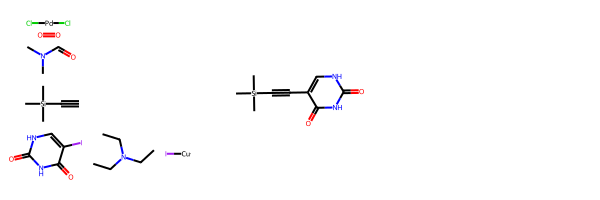

In [294]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in results['Lowe_rxn'].split('>>')])

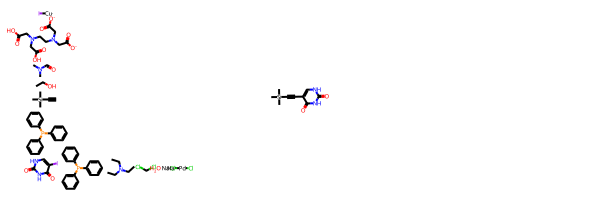

In [295]:
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in results['GPT_rxn'].split('>>')])

In [ ]:
'''
1. mi

'''